### Problem Statement

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

Demographics (city, age, gender etc.)
Tenure information (joining date, Last Date)
Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

In [382]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
import sklearn

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,5

# from sklearn import set_config
# set_config(transform_output="pandas")

In [383]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import KNNImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

In [384]:
df = pd.read_csv('ola_driver.csv')
print('Shape',df.shape)

Shape (19104, 14)


In [385]:
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [386]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [387]:
df.dtypes

MMM-YY                   object
Driver_ID                 int64
Age                     float64
Gender                  float64
City                     object
Education_Level           int64
Income                    int64
Dateofjoining            object
LastWorkingDate          object
Joining Designation       int64
Grade                     int64
Total Business Value      int64
Quarterly Rating          int64
dtype: object

In [388]:
#missing values
(df.isna().sum()/df.shape[0])*100

MMM-YY                   0.000000
Driver_ID                0.000000
Age                      0.319305
Gender                   0.272194
City                     0.000000
Education_Level          0.000000
Income                   0.000000
Dateofjoining            0.000000
LastWorkingDate         91.541039
Joining Designation      0.000000
Grade                    0.000000
Total Business Value     0.000000
Quarterly Rating         0.000000
dtype: float64

### Missing value - KNN imputer for Age and Gender columns

In [389]:
numeric_cols = df.select_dtypes(include='number').columns
df_imp = df[numeric_cols]

In [390]:
knn_imp = KNNImputer(n_neighbors=3)

In [391]:
imp_arr = knn_imp.fit_transform(df_imp)

In [392]:
df_imp = pd.DataFrame(imp_arr, columns=df_imp.columns)

In [393]:
df['Age'] = df_imp['Age'].round()
df['Gender'] = df_imp['Gender'].round()

In [394]:
#missing values
(df.isna().sum()/df.shape[0])*100

MMM-YY                   0.000000
Driver_ID                0.000000
Age                      0.000000
Gender                   0.000000
City                     0.000000
Education_Level          0.000000
Income                   0.000000
Dateofjoining            0.000000
LastWorkingDate         91.541039
Joining Designation      0.000000
Grade                    0.000000
Total Business Value     0.000000
Quarterly Rating         0.000000
dtype: float64

In [395]:
df['Gender'].value_counts()

0.0    11100
1.0     8004
Name: Gender, dtype: int64

In [396]:
#convert categorical columns to object dtype
df['Gender'] = df['Gender'].astype('object')
df['Education_Level'] = df['Education_Level'].astype('object')
df['Joining Designation'] = df['Joining Designation'].astype('object')
df['Grade'] = df['Grade'].astype('object')
df['Quarterly Rating'] = df['Quarterly Rating'].astype('object')

#convert date columns to date time dtype
df['MMM-YY'] = pd.to_datetime(df['MMM-YY'])
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'])

In [397]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19104 non-null  float64       
 3   Gender                19104 non-null  object        
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  object        
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  object        
 10  Grade                 19104 non-null  object        
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  object        
dtypes: datetime64[ns

In [398]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Driver_ID,19104.0,1415.591133,8.107053e+02,1.0,710.0,1417.0,2137.0,2788.0
Age,19104.0,34.662113,6.255011e+00,21.0,30.0,34.0,39.0,58.0
Income,19104.0,65652.025126,3.091452e+04,10747.0,42383.0,60087.0,83969.0,188418.0
Total Business Value,19104.0,571662.074958,1.128312e+06,-6000000.0,0.0,250000.0,699700.0,33747720.0


In [399]:
df.describe(include='object').T

,count,unique,top,freq
Gender,19104.0,2.0,0.0,11100.0
City,19104,29,C20,1008
Education_Level,19104,3,1,6864
Joining Designation,19104,5,1,9831
Grade,19104,5,2,6627
Quarterly Rating,19104,4,1,7679


In [400]:
df.describe(include='datetime').T

,count,unique,top,freq,first,last
MMM-YY,19104,24,2019-01-01,1022,2019-01-01,2020-12-01
Dateofjoining,19104,869,2015-07-23,192,2013-04-01,2020-12-28
LastWorkingDate,1616,493,2020-07-29,70,2018-12-31,2020-12-28


#### <span style='color:red'>Observations</span>

1. Age mean and median are same and in range of 21-58.
2. Income mean and median are almost equal ~60k.
3. Total business value in range -6M to 33.7M where mean and median are not equal, possibility of outliers is there.
4. Majority value for gender is Male.
5. City has 29 unique types where C20 is on top.
6. Quartely rating 1 is on top with 7679 counts.
7. We have reporting data from jan 2019 till dec 2020.
8. Joining date 23-7-2015 is on top with 192 freq and in range from apr 13 till dec 20.
9. LWD is in range from July 18 till dec 20.
10. Dataset has missing values for age, gender and lwd 0.3%, 0.27 and 91% respectively.

### Groupby data at driver level

In [401]:
df[df.Driver_ID==21]

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
74,2019-01-01,21,33.0,1.0,C29,1,22755,2018-05-12,NaT,1,1,948560,4
75,2019-02-01,21,33.0,1.0,C29,1,22755,2018-05-12,NaT,1,1,551740,4
76,2019-03-01,21,33.0,1.0,C29,1,22755,2018-05-12,NaT,1,1,3295370,4
77,2019-04-01,21,33.0,1.0,C29,1,22755,2018-05-12,NaT,1,1,0,2
78,2019-05-01,21,33.0,1.0,C29,1,22755,2018-05-12,NaT,1,1,116350,2
79,2019-06-01,21,33.0,1.0,C29,1,22755,2018-05-12,NaT,1,1,533260,2
80,2019-07-01,21,33.0,1.0,C29,1,22755,2018-05-12,NaT,1,1,150450,2
81,2019-08-01,21,33.0,1.0,C29,1,22755,2018-05-12,NaT,1,1,0,2
82,2019-09-01,21,33.0,1.0,C29,1,22755,2018-05-12,NaT,1,1,520980,2
83,2019-10-01,21,33.0,1.0,C29,1,22755,2018-05-12,NaT,1,1,150600,2


In [402]:
#get unique values for income and quar ratings
def get_unqiue(row):
    res = list()
    for a in row:
        if a not in res:
            res.append(a)
    return res

#get quarterly rating and income indicator
def increase_ind(row):
    if len(row)>1:
        if int(row[-1]) > int(row[0]):
            return 1
        else:
            return 0
    else:
        return 0


`We need flags for Income and quar-rating in case increment so lets preserve all unique values in order and later compare first and last value to create new feature.`

In [403]:
df_gp = df.groupby('Driver_ID')
df_gp = df_gp.aggregate({'MMM-YY':'last',
                 'Age':max,
                 'Gender':max,
                 'City':'last',
                 'Education_Level':'last',
                 'Income':get_unqiue,
                 'Dateofjoining':'last',
                 'LastWorkingDate':'last',
                 'Joining Designation':'last',
                 'Grade':'last',
                 'Total Business Value':sum,
                 'Quarterly Rating':get_unqiue
})

In [404]:
df_gp.reset_index(inplace=True)

### Feature engineering

In [405]:
df_gp['income_inc'] = df_gp['Income'].apply(increase_ind)
df_gp['quar_rating_inc'] = df_gp['Quarterly Rating'].apply(increase_ind)
df_gp['target'] = df_gp['LastWorkingDate'].apply(lambda x : 1 if str(x)!='NaT' else 0)

In [406]:
df_gp['joiningMonth'] = df_gp['Dateofjoining'].dt.month
df_gp['joiningYear'] = df_gp['Dateofjoining'].dt.year

In [407]:
df_gp['Income'] = df_gp['Income'].apply(lambda x: x[-1])
df_gp['Quarterly Rating'] = df_gp['Quarterly Rating'].apply(lambda x: x[-1])

In [408]:
df_gp.sample(5)

,Driver_ID,MMM-YY,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,income_inc,quar_rating_inc,target,joiningMonth,joiningYear
2355,2758,2020-03-01,33.0,0.0,C26,1,69141,2019-11-07,2020-03-23,2,2,590220,1,0,0,1,11,2019
37,50,2019-02-01,49.0,1.0,C5,0,89367,2018-11-20,2019-02-20,3,3,110310,1,0,0,1,11,2018
2251,2637,2019-04-01,41.0,0.0,C15,0,19724,2017-09-12,2019-04-26,1,1,1464860,1,0,0,1,9,2017
1202,1414,2020-12-01,31.0,1.0,C29,1,47329,2017-11-06,NaT,1,2,20941450,4,0,1,0,11,2017
1710,2013,2019-08-01,37.0,1.0,C20,2,59274,2018-05-15,2019-08-05,1,1,3015730,2,0,0,1,5,2018


### Remvoe unnecessary columns

In [409]:
drop_cols = ['Driver_ID', 'MMM-YY', 'Dateofjoining', 'LastWorkingDate']
df_gp.drop(drop_cols, axis=1, inplace=True)

In [410]:
df_gp.sample(5)

,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,income_inc,quar_rating_inc,target,joiningMonth,joiningYear
1771,30.0,1.0,C22,2,50787,1,1,3991680,1,0,0,1,7,2018
1841,37.0,1.0,C23,0,45604,1,1,0,1,0,0,1,8,2019
1976,29.0,0.0,C28,2,23334,1,1,399460,1,0,0,1,1,2020
373,40.0,0.0,C16,1,113125,2,4,16391700,3,0,1,0,8,2013
1906,49.0,1.0,C3,0,53572,1,2,3408200,1,0,0,1,8,2015


### Univariate analysis

In [411]:
df_gp['Age'].value_counts()

31.0    169
32.0    169
34.0    167
30.0    154
33.0    147
36.0    141
35.0    139
29.0    131
37.0    125
28.0    120
27.0    105
38.0     98
39.0     87
25.0     78
41.0     76
26.0     69
40.0     63
42.0     53
43.0     41
24.0     41
44.0     36
23.0     36
46.0     28
45.0     27
47.0     19
48.0     13
49.0     11
22.0     11
52.0      8
51.0      6
50.0      5
21.0      2
53.0      2
55.0      2
54.0      1
58.0      1
Name: Age, dtype: int64

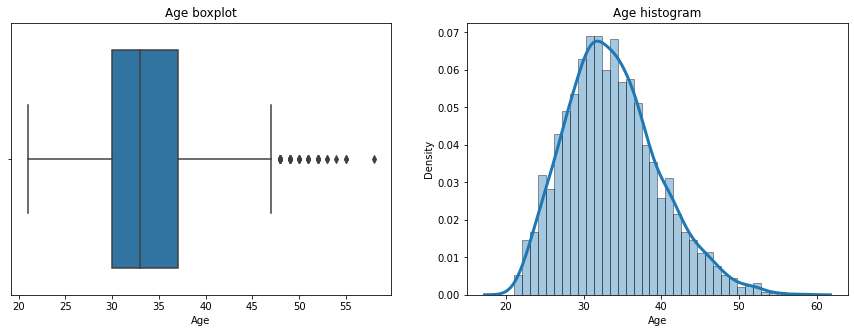

In [412]:
col = df_gp['Age']
col_name = 'Age'

plt.subplot(1,2,1)
sns.boxplot(col)
plt.title(col_name+' boxplot')
plt.subplot(1,2,2)
sns.distplot(col ,hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 3})
plt.title(col_name+' histogram')
plt.show()

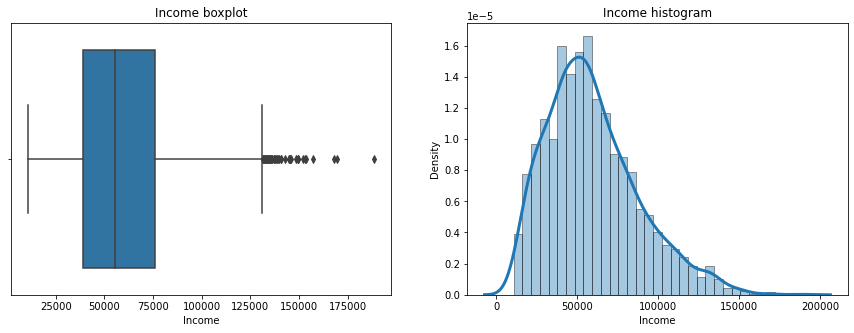

In [413]:
col = df_gp['Income']
col_name = 'Income'

plt.subplot(1,2,1)
sns.boxplot(col)
plt.title(col_name+' boxplot')
plt.subplot(1,2,2)
sns.distplot(col ,hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 3})
plt.title(col_name+' histogram')
plt.show()

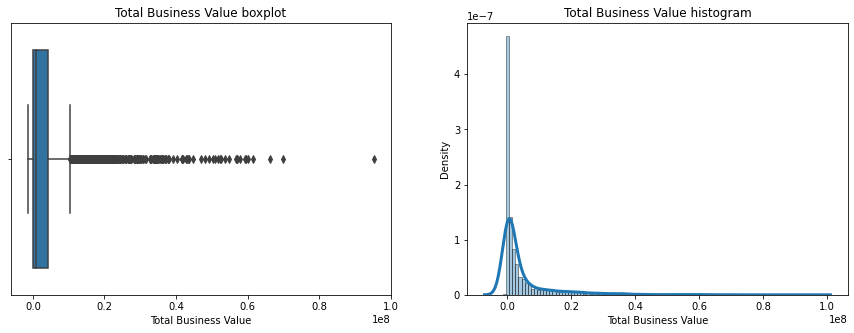

In [414]:
col = df_gp['Total Business Value']
col_name = 'Total Business Value'

plt.subplot(1,2,1)
sns.boxplot(col)
plt.title(col_name+' boxplot')
plt.subplot(1,2,2)
sns.distplot(col ,hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 3}, bins=100)
plt.title(col_name+' histogram')
plt.show()

In [415]:
df_gp['Gender'].value_counts(normalize=True)

0.0    0.584628
1.0    0.415372
Name: Gender, dtype: float64

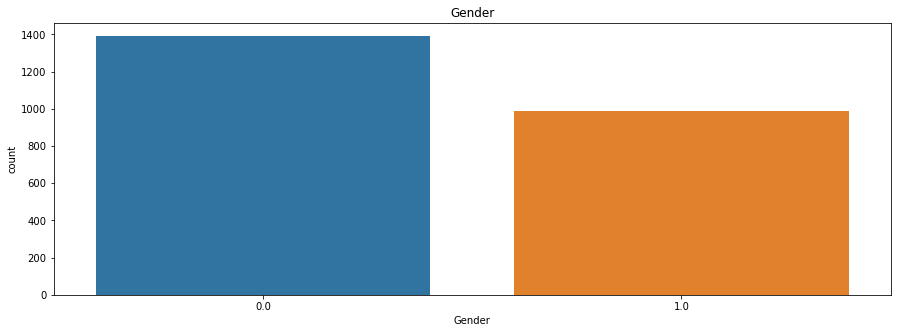

In [416]:
col = df_gp['Gender']
col_name = 'Gender'
sns.countplot(col)
plt.title(col_name)
plt.show()

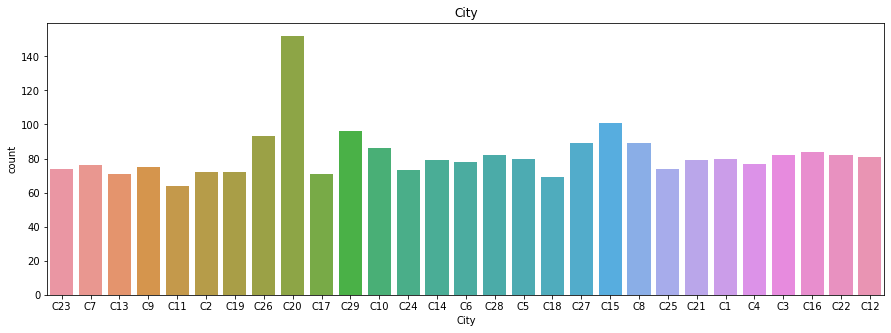

In [417]:
col = df_gp['City']
col_name = 'City'
sns.countplot(col)
plt.title(col_name)
plt.show()

In [418]:
df_gp['Education_Level'].value_counts()

2    802
1    795
0    784
Name: Education_Level, dtype: int64

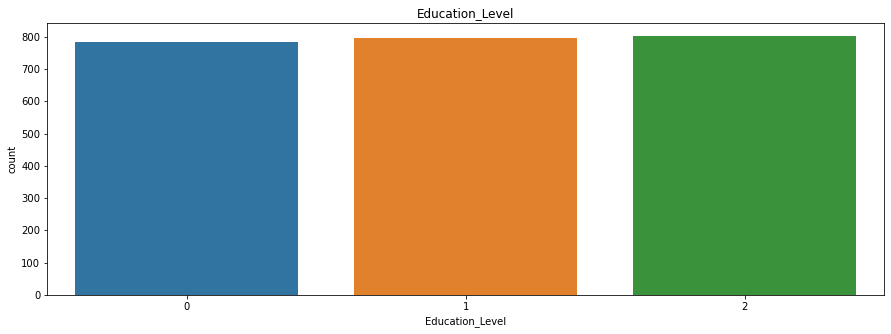

In [419]:
col = df_gp['Education_Level']
col_name = 'Education_Level'
sns.countplot(col)
plt.title(col_name)
plt.show()

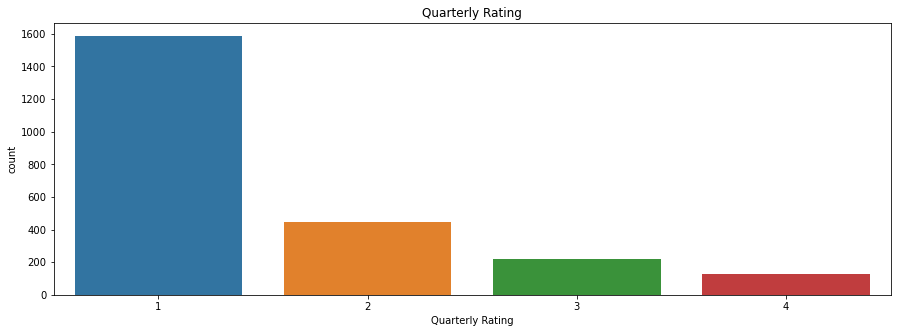

In [420]:
col = df_gp['Quarterly Rating']
col_name = 'Quarterly Rating'
sns.countplot(col)
plt.title(col_name)
plt.show()

In [421]:
df_gp['target'].value_counts(normalize=True)

1    0.678706
0    0.321294
Name: target, dtype: float64

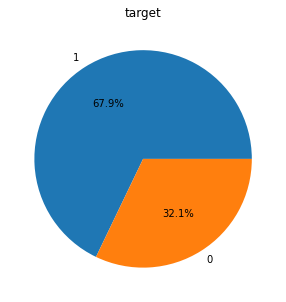

In [422]:
col = df_gp['target']
col_name = 'target'
plt.pie(col.value_counts(), autopct='%1.1f%%', labels=col.value_counts().index)
plt.title(col_name)
plt.show()

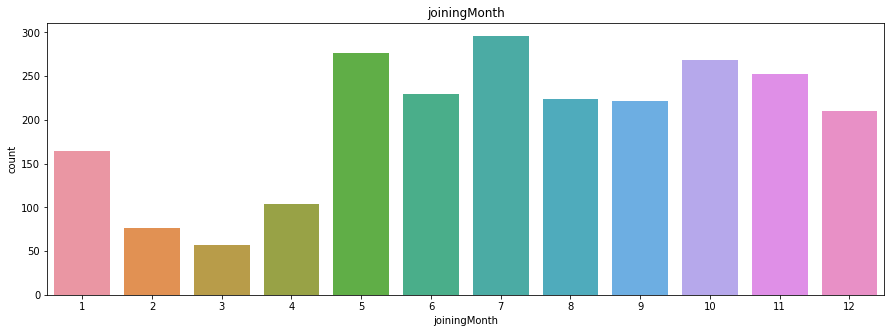

In [423]:
col = df_gp['joiningMonth']
col_name = 'joiningMonth'
sns.countplot(col)
plt.title(col_name)
plt.show()

#### <span style='color:red'>Observations</span>

1. Age is following bell shape curve with some outliers in right tail.
2. Income is also following almost bell shape curved where median is around 50k.
3. Total business value is showing a very long right tail with some signs of outliers.
4. Gender is in 58-42 ratio.
5. C20 city is on top.
6. All education levels are with same ratio.
7. Most of the drivers got rating 1.
8. 68% drivers left the company.
9. Most of the drivers joined in July month.

### Bivariate anaylysis

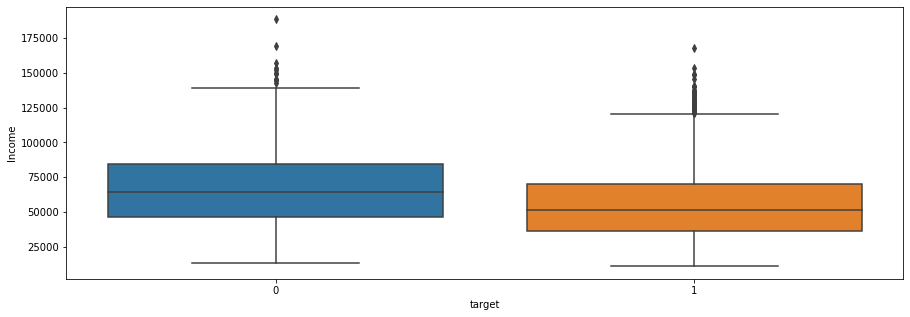

In [424]:
sns.boxplot(y=df_gp['Income'], x=df_gp['target'])
plt.show()

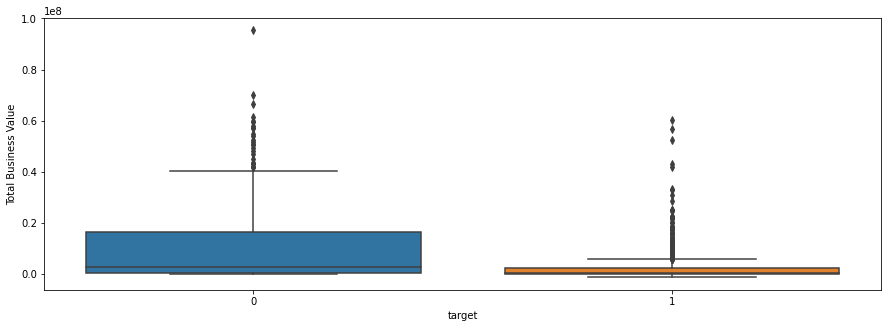

In [425]:
sns.boxplot(y=df_gp['Total Business Value'], x=df_gp['target'])
plt.show()

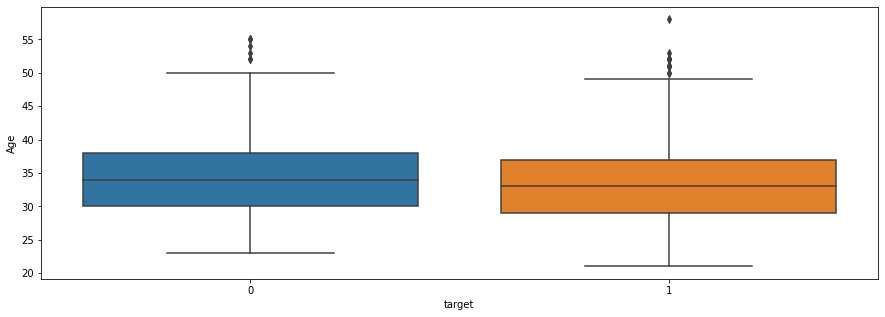

In [426]:
sns.boxplot(y=df_gp['Age'], x=df_gp['target'])
plt.show()

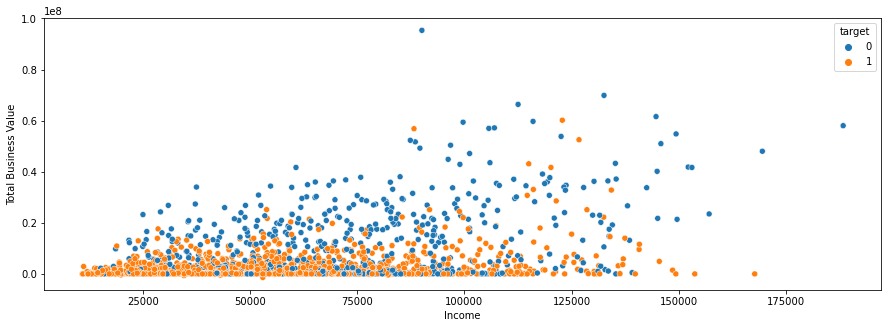

In [427]:
sns.scatterplot(x=df_gp['Income'], y=df_gp['Total Business Value'], hue=df_gp['target'])
plt.show()

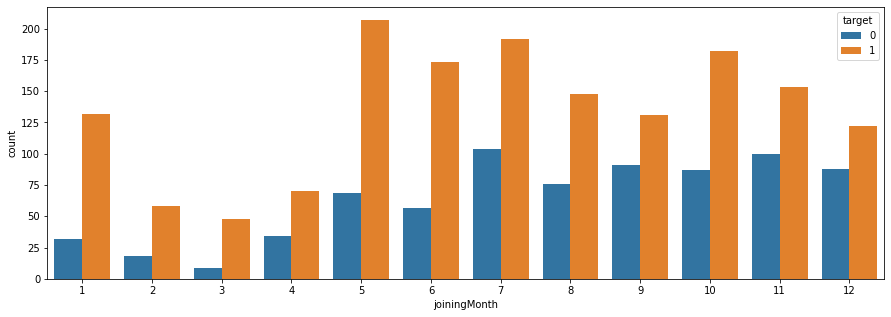

In [428]:
sns.countplot(df_gp['joiningMonth'], hue=df_gp['target'])
plt.show()

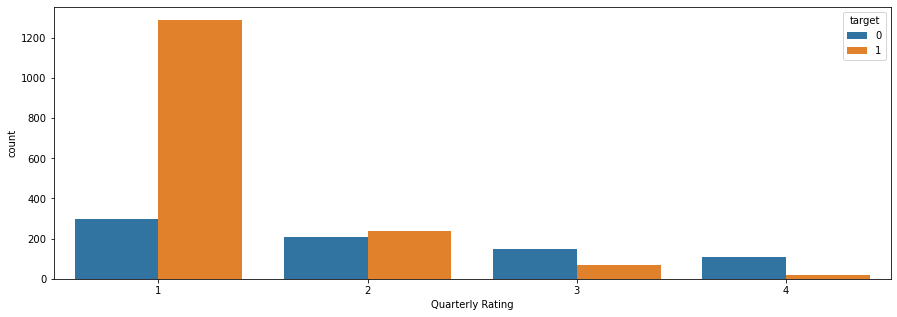

In [429]:
sns.countplot(df_gp['Quarterly Rating'], hue=df_gp['target'])
plt.show()

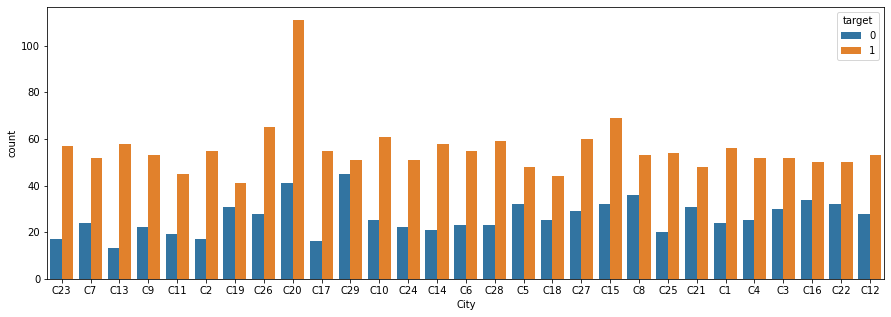

In [430]:
sns.countplot(df_gp['City'], hue=df_gp['target'])
plt.show()

#### <span style='color:red'>Observations</span>
1. Income and total business value medians are less for who left the company.
2. Age median is same for both categories.
3. Most of the drivers left the company whose total business value is very less.
4. Who got rating 3 and 4, are less towards on decision to left the company.

### Encoding

In [431]:
from category_encoders import TargetEncoder

te = TargetEncoder()
df_gp['City'] = te.fit_transform(df_gp['City'], df_gp['target'])

In [432]:
for col in df_gp.columns:
    df_gp[col] = df_gp[col].astype('float64')

In [433]:
df_gp.head()

,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,income_inc,quar_rating_inc,target,joiningMonth,joiningYear
0,28.0,0.0,0.770270,2.0,57387.0,1.0,1.0,1715580.0,2.0,0.0,0.0,1.0,12.0,2018.0
1,31.0,0.0,0.684211,2.0,67016.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,11.0,2020.0
2,43.0,0.0,0.816901,2.0,65603.0,2.0,2.0,350000.0,1.0,0.0,0.0,1.0,12.0,2019.0
3,29.0,0.0,0.706667,0.0,46368.0,1.0,1.0,120360.0,1.0,0.0,0.0,1.0,1.0,2019.0
4,31.0,1.0,0.703125,1.0,78728.0,3.0,3.0,1265000.0,2.0,0.0,1.0,0.0,7.0,2020.0


### Multivariate anaylsis

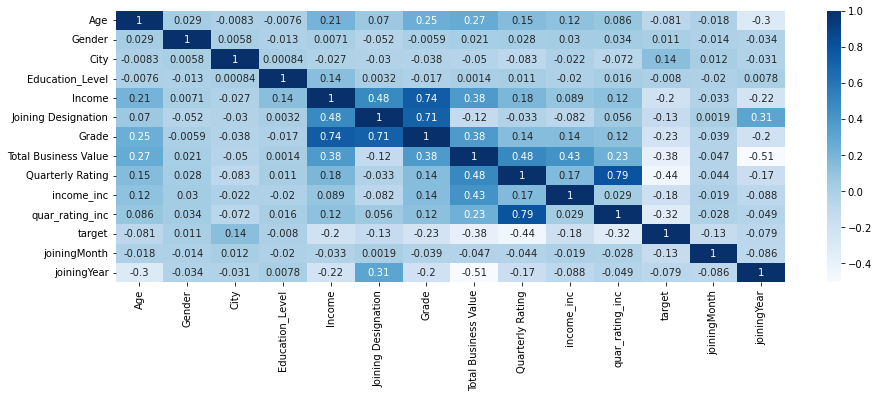

In [434]:
sns.heatmap(df_gp.corr(), cmap='Blues', annot=True)
plt.show()

#### <span style='color:red'>Observations</span>

1. Grade-Income are highly correlated with each other.
2. Grade - joining designation are highly correlated with each other.
3. Joining year is not much relevant for target.

### Model Training

### Classification metric
- Precision: In all predicted drivers , most of them will leave the company.
- Recall: In all actual drivers, most of them have actually left the company.

`In this case both precision and recall matter but slightly recall is more important compare to precision.`<br>
`If we are getting false positive thats fine but we cant lose out actual drivers who left the company. We can go with f1 score as metric.`

### Imbalanced Data


In [435]:
df_gp['target'].value_counts(normalize=True)

1.0    0.678706
0.0    0.321294
Name: target, dtype: float64

- Target variable is not balanced its in 2:1 ratio.
- We can use class weights to make it balanced while model training.

#### <span style='color:green'>Ensemble - Bagging - Random forest</span>

In [436]:
y = df_gp['target']
X = df_gp.drop('target', axis=1)

### Train-Test Dataset

In [437]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

### Standardization

In [438]:
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_train.head()

,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,income_inc,quar_rating_inc,joiningMonth,joiningYear
344,1.187355,1.184922,2.082896,-0.012542,-0.022811,-0.946571,-0.087106,1.316151,0.527069,-0.135416,-0.575964,-0.749798,-1.571238
1615,-1.301698,-0.843937,0.623015,1.216549,-0.883623,-0.946571,-1.138687,-0.506421,-0.607423,-0.135416,-0.575964,-0.431377,0.930728
992,-0.803887,-0.843937,1.383887,-1.241632,-1.264215,-0.946571,-0.087106,-0.271868,0.527069,-0.135416,1.736219,0.205463,-0.945746
2097,-0.306077,1.184922,0.430459,1.216549,0.948320,0.223301,-0.087106,-0.476226,-0.607423,-0.135416,-0.575964,1.479145,0.305237
2244,-1.467635,1.184922,-1.054643,-1.241632,-1.575726,-0.946571,-1.138687,-0.506421,-0.607423,-0.135416,-0.575964,-1.068218,0.930728


In [439]:
def checkVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

In [440]:
def get_cv_res(estimator, X_train, y_train):
    cv_results = cross_validate(estimator, X_train, y_train, cv=5, scoring='f1', return_train_score=True, n_jobs=-1)
    print(f"Train score: {cv_results['train_score'].mean()*100}, \nVal score: {cv_results['test_score'].mean()*100}") 

In [441]:
import time
def get_gridsearch_res(estimator, X_train, y_train, params):
    """
    returns:
    best_estimator, cv_results_df
    """
    stime = time.time()
    grid_res = GridSearchCV(estimator, params, cv=3, return_train_score=True, n_jobs=-1, verbose=1, scoring='f1')
    grid_res.fit(X_train, y_train)
    etime = time.time()
    
    print(f'Grid search time: {etime-stime}')
    print(f'best score: {grid_res.best_score_}')
    print(f'best params: {grid_res.best_params_}')
    # print(pd.DataFrame(grid_res.cv_results_).sort_values('rank_test_score')[:5])
    return grid_res.best_estimator_, pd.DataFrame(grid_res.cv_results_).sort_values('rank_test_score')

In [442]:
rfc = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

In [443]:
get_cv_res(rfc, X_train, y_train)

Train score: 100.0, 
Val score: 92.79291218585074


`There is large difference between train and test accuracy, it showed there is high variance as overfit`<br>
`Lets do hyperparameter training to reduce variance`

### VIF

In [444]:
checkVIF(X)

,Features,VIF
12,joiningYear,161.26
2,City,109.09
0,Age,36.94
6,Grade,31.05
5,Joining Designation,18.80
8,Quarterly Rating,15.51
4,Income,13.11
11,joiningMonth,6.51
10,quar_rating_inc,4.03
7,Total Business Value,3.46


In [445]:
get_cv_res(rfc, X_train.drop(['joiningYear', 'City', 'Grade', 'Age'], axis=1), y_train)

Train score: 100.0, 
Val score: 85.90810464588701


`Val Accuracy reduced after removing high VIF scores features.`

### Gridsearch CV

In [446]:
rf_params = {'n_estimators':[100,150,200,250], 'max_depth':[6,7,8,9,10], 'min_samples_split':[5,8,10], 'ccp_alpha':[0, 0.5]}

In [447]:
rfc_best_est, cv_res_df = get_gridsearch_res(rfc, X_train, y_train, rf_params)
cv_res_df[:5]

Fitting 3 folds for each of 120 candidates, totalling 360 fits
Grid search time: 33.630316972732544
best score: 0.9295265486961862
best params: {'ccp_alpha': 0, 'max_depth': 9, 'min_samples_split': 5, 'n_estimators': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
36,0.325829,0.107361,0.043922,0.017351,0,9,5,100,"{'ccp_alpha': 0, 'max_depth': 9, 'min_samples_...",0.924101,0.938503,0.925976,0.929527,0.006393,1,0.977394,0.977985,0.979973,0.978451,0.001103
37,0.502150,0.072098,0.034600,0.011828,0,9,5,150,"{'ccp_alpha': 0, 'max_depth': 9, 'min_samples_...",0.933155,0.929919,0.920378,0.927817,0.005424,2,0.980680,0.982036,0.977985,0.980234,0.001683
48,0.325354,0.013733,0.030793,0.005260,0,10,5,100,"{'ccp_alpha': 0, 'max_depth': 10, 'min_samples...",0.932271,0.934579,0.916442,0.927764,0.008061,3,0.984656,0.984656,0.985333,0.984882,0.000319
55,0.898613,0.128610,0.048904,0.004947,0,10,8,250,"{'ccp_alpha': 0, 'max_depth': 10, 'min_samples...",0.927807,0.938172,0.915761,0.927247,0.009158,4,0.975251,0.972539,0.970470,0.972753,0.001958
49,0.705906,0.036862,0.034017,0.003928,0,10,5,150,"{'ccp_alpha': 0, 'max_depth': 10, 'min_samples...",0.929615,0.931727,0.916216,0.925853,0.006868,5,0.984677,0.985333,0.982012,0.984007,0.001436


`Still there is 5% accuracy difference bw train -test accuracies.`

In [448]:
y_train_pred = rfc_best_est.predict(X_train)
y_test_pred = rfc_best_est.predict(X_test)

print('Train score: ',f1_score(y_train, y_train_pred))
print('Test score: ',f1_score(y_test, y_test_pred))

Train score:  0.9728768341485104
Test score:  0.9125395152792413


`Model is overfitted as large gap between scores, lets try boosting algos.`

#### <span style='color:green'>Ensemble - Boosting - GBDT</span>

In [449]:
gbdt_clf = GradientBoostingClassifier()

In [450]:
get_cv_res(gbdt_clf, X_train, y_train)

Train score: 96.70299307487677, 
Val score: 92.77799882862713


`There is only 4 % difference bw train-val scores, slightly overfit, lets do hyperparameter tuning.`

In [451]:
gbdt_params = {'n_estimators':[50,100,150,200], 'learning_rate':[0.1,0.3,0.5], 'subsample':[0.3,0.5,1], 
               'min_samples_split':[2,5,10], 'max_depth':[3,4,5]}

In [452]:
gbdt_best, gbdt_cv_res = get_gridsearch_res(gbdt_clf, X_train, y_train, gbdt_params)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Grid search time: 69.47872114181519
best score: 0.9290918097961384
best params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 50, 'subsample': 1}


In [453]:
gbdt_cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_samples_split,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
26,0.257601,0.010765,0.002088,0.000091,0.1,3,10,50,1,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa...",0.933333,0.936170,0.917772,0.929092,0.008088,1,0.952507,0.949669,0.957950,0.953375,0.003436
10,0.471075,0.029317,0.003266,0.000075,0.1,3,2,200,0.5,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa...",0.935611,0.936340,0.913747,0.928566,0.010483,2,0.988095,0.988111,0.993404,0.989870,0.002499
60,0.172698,0.049382,0.003307,0.001657,0.1,4,10,50,0.3,"{'learning_rate': 0.1, 'max_depth': 4, 'min_sa...",0.940397,0.930851,0.914439,0.928562,0.010721,3,0.959103,0.962963,0.960849,0.960972,0.001578
40,0.277031,0.003800,0.002657,0.000029,0.1,4,2,100,0.5,"{'learning_rate': 0.1, 'max_depth': 4, 'min_sa...",0.931398,0.933511,0.920000,0.928303,0.005934,4,0.988764,0.982202,0.990073,0.987013,0.003444
5,0.599589,0.049787,0.004130,0.001364,0.1,3,2,100,1,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa...",0.931579,0.936340,0.916890,0.928270,0.008278,5,0.968379,0.969536,0.975674,0.971197,0.003201


In [454]:
y_train_pred = gbdt_best.predict(X_train)
y_test_pred = gbdt_best.predict(X_test)

print('Train score: ',f1_score(y_train, y_train_pred))
print('Test score: ',f1_score(y_test, y_test_pred))

Train score:  0.9458388375165125
Test score:  0.9219562955254942


`Model is less overfitted comapre to RF but with less training f1 score.`

In [455]:
pd.DataFrame(np.array([X_train.columns, gbdt_best.feature_importances_]).T, 
             columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

,Feature,Importance
12,joiningYear,0.320497
7,Total Business Value,0.254249
11,joiningMonth,0.220008
8,Quarterly Rating,0.156477
2,City,0.015607
4,Income,0.013681
0,Age,0.008689
5,Joining Designation,0.005683
6,Grade,0.001994
1,Gender,0.001755


In [456]:
gbdt_best.feature_importances_

array([0.00868856, 0.00175513, 0.01560683, 0.00061672, 0.01368102,
       0.00568336, 0.00199368, 0.25424909, 0.15647725, 0.        ,
       0.00074305, 0.22000794, 0.32049738])

#### <span style='color:green'>Ensemble - Boosting - XGBoost</span>

In [457]:
from xgboost import XGBClassifier

In [458]:
xgb_clf = XGBClassifier(n_jobs=-1, scale_pos_weight=2)

In [459]:
get_cv_res(xgb_clf, X_train, y_train)

Train score: 100.0, 
Val score: 92.50761374702158


In [460]:
xg_params = {'n_estimators':[50,100,150,200], 'learning_rate':[0.1,0.3,0.5], 'subsample':[0.3,0.5,1], 'max_depth':[3,4,5]}

In [461]:
xg_best, xg_cv_res = get_gridsearch_res(xgb_clf, X_train, y_train, xg_params)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Grid search time: 7.742735862731934
best score: 0.927384877643945
best params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1}


In [462]:
xg_cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
17,0.131142,0.003567,0.004448,0.001510,0.1,4,100,1,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.935233,0.935233,0.911688,0.927385,0.011099,1,0.978558,0.977836,0.979831,0.978741,0.000825
8,0.154637,0.007298,0.006400,0.002093,0.1,3,150,1,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.936774,0.933680,0.910506,0.926987,0.011722,2,0.972798,0.972763,0.974692,0.973417,0.000901
107,0.293680,0.021906,0.007384,0.002507,0.5,5,200,1,"{'learning_rate': 0.5, 'max_depth': 5, 'n_esti...",0.936842,0.935611,0.905914,0.926122,0.014298,3,1.000000,1.000000,1.000000,1.000000,0.000000
5,0.114765,0.009756,0.004435,0.001955,0.1,3,100,1,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.933333,0.933680,0.910968,0.925994,0.010626,4,0.962629,0.958869,0.966365,0.962621,0.003060
29,0.181324,0.003335,0.006511,0.001977,0.1,5,100,1,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.932292,0.932292,0.913158,0.925914,0.009020,5,0.990789,0.987557,0.992758,0.990368,0.002144


In [463]:
y_train_pred = xg_best.predict(X_train)
y_test_pred = xg_best.predict(X_test)

print('Train score: ',f1_score(y_train, y_train_pred))
print('Test score: ',f1_score(y_test, y_test_pred))

Train score:  0.9727861771058315
Test score:  0.9211873080859775


`XGBoost is slightly overfitted compare to GBDT.`

### Metrics analysis for Random forst and GBDT.

### Random forest

In [464]:
y_pred = rfc_best_est.predict_proba(X_test)[:,1]

In [465]:
def get_pr_re_curve(y_test, y_pred):
    pr, re, thresh = precision_recall_curve(y_test, y_pred)
    threshold_boundary = thresh.shape[0]
    plt.plot(thresh, pr[0:threshold_boundary], linestyle='--', label='precisions')
    plt.plot(thresh, re[0:threshold_boundary], label='recalls')
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.05), 2))
    plt.xlabel('Threshold Value')
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    plt.show()

In [466]:
def get_roc_curve(y_test, y_proba):
    score = roc_auc_score(y_test, y_proba).round(2)
    fpr, tpr, thresh = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label='ROC AUC (area = %0.2f)' % score)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

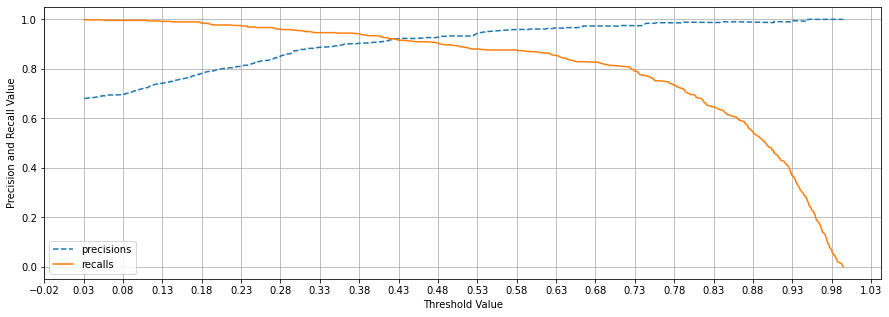

In [467]:
get_pr_re_curve(y_test, y_pred)

`By seeing the pr-recall curvem 0.42 threshold looks good where precision and recall curve are intersecting with each other.`

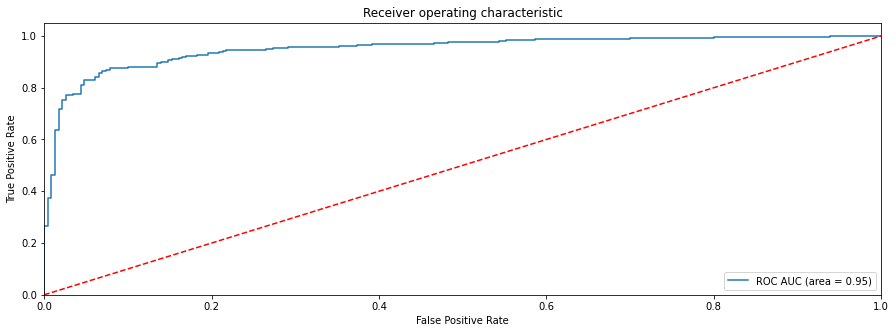

In [468]:
get_roc_curve(y_test, y_pred)

In [469]:
y_pred_label = np.where(y_pred > 0.42, 1, 0)

In [470]:
def get_metrics(y_test, y_pred):
    pr = precision_score(y_test, y_pred).round(2)
    re = recall_score(y_test, y_pred).round(2)
    f1 = f1_score(y_test, y_pred).round(2)
    print(f'Precision: {pr} \nRecall: {re} \nF1 score: {f1}')
    

In [471]:
get_metrics(y_test, y_pred_label)

Precision: 0.92 
Recall: 0.92 
F1 score: 0.92


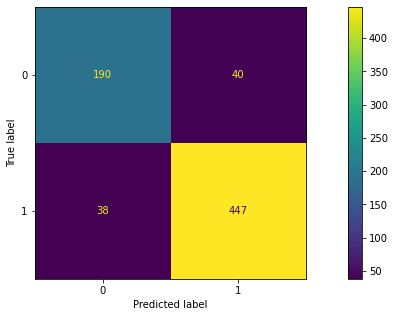

In [472]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_label)).plot()
plt.show()

In [473]:
print(classification_report(y_test, y_pred_label))

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       230
         1.0       0.92      0.92      0.92       485

    accuracy                           0.89       715
   macro avg       0.88      0.87      0.87       715
weighted avg       0.89      0.89      0.89       715



### GBDT

In [474]:
y_pred = gbdt_best.predict_proba(X_test)[:,1]

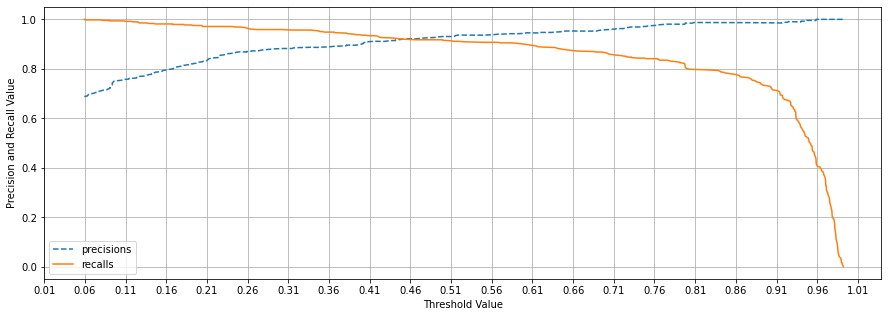

In [475]:
get_pr_re_curve(y_test, y_pred)

`By seeing the pr-recall curvem 0.46 threshold looks good where precision and recall curve are intersecting with each other.`

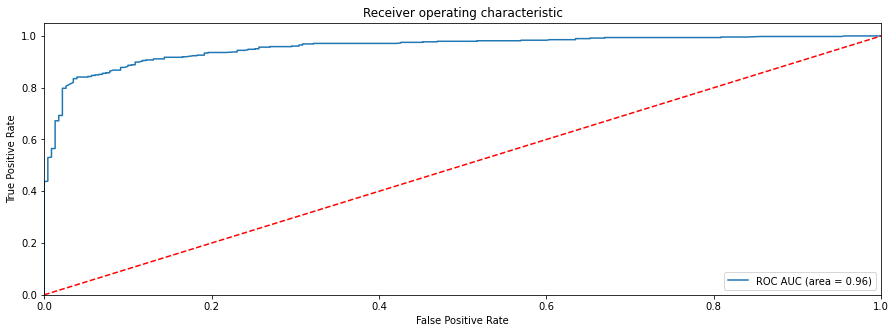

In [476]:
get_roc_curve(y_test, y_pred)

In [477]:
y_pred_label = np.where(y_pred > 0.46, 1, 0)

In [478]:
get_metrics(y_test, y_pred_label)

Precision: 0.92 
Recall: 0.92 
F1 score: 0.92


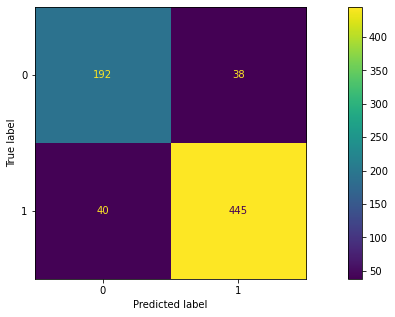

In [479]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_label)).plot()
plt.show()

In [480]:
print(classification_report(y_test, y_pred_label))

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       230
         1.0       0.92      0.92      0.92       485

    accuracy                           0.89       715
   macro avg       0.87      0.88      0.88       715
weighted avg       0.89      0.89      0.89       715



#### <span style='color:red'>Observations</span>
1. AUC for GBDT is higher compare to RF that is 96.
2. Precision, recall and f1 score same for both with 92 value.
3. All other score in classification report are almost same in both RF and GBDT classifiers but GBDT is slightly good. so we can go with GBDT.
4. GBDT AUC score in 96 that is very good as we can easily distinghish between both classes.
5. In our case, f1 score is best metric for analysis but if we want to give more weightage to recall, we can change threshold with the help of  PR-Recall curve.

#### <span style='color:red'>Insights</span>

1. In total business value, we have outliers.
2. Both gender are in 58:42 ratio.
3. Most of the drivers belong to C20 city.
4. Mostly drivers got rating 1 only.
5. 68% drivers left the company.
6. Random forest, GBDT and XGboost models performances are almost same.
7. GBDT has slightly better performed with 94.5% train f1 score and 92% test f1 score.
8. Consider both precision and recall metrics, 46% threshold is best by precision-recall curve.
9. ROC AUC score is 96%.
10. Most important features for GBDT models are: Joining Year, Total Business value and Joining Month.

#### <span style='color:red'>Recommendations</span>

1. Model can predict driver attrition chances with high confidence.
2. Business should release survey to drivers to understand pain points.
3. From the survey results, business should take key things and provide some trainings to drivers so they can perform better in coming months.
4. Drivers should do long working hours to increse total business value.
5. Cities c26, c20 and c15 have high attrition rate, business should do some campigns there to understand drivers concerns.
6. By model prediction, business should target drivers those have high prediction of attrition in near future and provide them 1-1 counselling.
7. With more relevant features for attrition, we can re-train model to provide results more confidently.